In [14]:
from PIL import Image
import requests
import torch
from torchvision import io
import numpy as np
from typing import Dict
import math
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

In [2]:
# Load the model in half-precision on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

##### Example image processing

In [32]:
from qwen_vl_utils import process_vision_info
from transformers import AutoProcessor
import matplotlib.pyplot as plt

from transformers.image_utils import(
    make_flat_list_of_images,
    make_list_of_images,
    to_numpy_array,
    infer_channel_dimension_format,
    get_image_size,
    ChannelDimension,
)

from transformers.image_transforms import resize, rescale, normalize, to_channel_dimension_format

In [2]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

In [30]:
processor

Qwen2VLProcessor:
- image_processor: Qwen2VLImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "Qwen2VLImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "max_pixels": 12845056,
  "merge_size": 2,
  "min_pixels": 3136,
  "patch_size": 14,
  "processor_class": "Qwen2VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 12845056,
    "shortest_edge": 3136
  },
  "temporal_patch_size": 2
}

- tokenizer: Qwen2TokenizerFast(name_or_path='Qwen/Qwen2-VL-7B-Instruct', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start

In [15]:
def smart_resize(
    height: int, width: int, factor: int = 28, min_pixels: int = 56 * 56, max_pixels: int = 14 * 14 * 4 * 1280
):
    """Rescales the image so that the following conditions are met:

    1. Both dimensions (height and width) are divisible by 'factor'.

    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].

    3. The aspect ratio of the image is maintained as closely as possible.

    """
    if height < factor or width < factor:
        raise ValueError(f"height:{height} or width:{width} must be larger than factor:{factor}")
    elif max(height, width) / min(height, width) > 200:
        raise ValueError(
            f"absolute aspect ratio must be smaller than 200, got {max(height, width) / min(height, width)}"
        )
    h_bar = round(height / factor) * factor
    w_bar = round(width / factor) * factor
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = math.floor(height / beta / factor) * factor
        w_bar = math.floor(width / beta / factor) * factor
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = math.ceil(height * beta / factor) * factor
        w_bar = math.ceil(width * beta / factor) * factor
    return h_bar, w_bar

(2, 3, 1372, 2044)


RuntimeError: No active exception to reraise

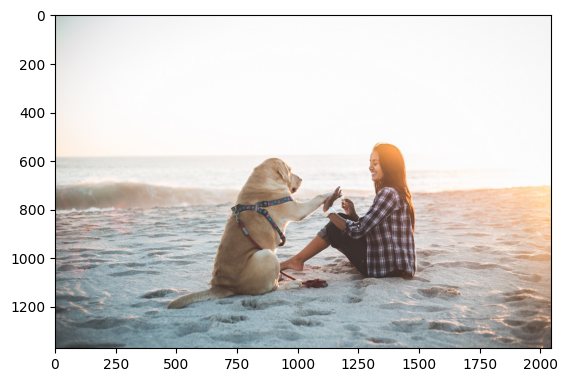

In [41]:
max_pixels = 12845056
merge_size = 2
min_pixels = 3136
patch_size = 14
resample = 3
rescale_factor = 0.00392156862745098
temporal_patch_size = 2

images = make_flat_list_of_images(image_inputs)
images = make_list_of_images(images[0])
images = [to_numpy_array(image) for image in images]
input_data_format = infer_channel_dimension_format(images[0])

height, width = get_image_size(images[0], channel_dim=input_data_format)
resized_height, resized_width = height, width

processed_images = []
for image in images:
    resized_height, resized_width = smart_resize(
        height,
        width,
        factor=patch_size * merge_size,
        min_pixels=min_pixels,
        max_pixels=max_pixels,
    )
    image = resize(
        image, size=(resized_height, resized_width), resample=resample, input_data_format=input_data_format
    )
    image = rescale(image, scale=rescale_factor, input_data_format=input_data_format)
    image = to_channel_dimension_format(image, ChannelDimension.FIRST, input_channel_dim=input_data_format)
    processed_images.append(image)
    
patches = np.array(processed_images)

if patches.shape[0] % temporal_patch_size != 0:
    repeats = np.repeat(patches[-1][np.newaxis], temporal_patch_size - 1, axis=0)
    patches = np.concatenate([patches, repeats], axis=0)

#print(patches.shape)
#plt.imshow(patches[1].transpose(1,2,0))
#raise

channel = patches.shape[1]
grid_t = patches.shape[0] // temporal_patch_size
grid_h, grid_w = resized_height // patch_size, resized_width // patch_size
patches = patches.reshape(
    grid_t,
    temporal_patch_size,
    channel,
    grid_h // merge_size,
    merge_size,
    patch_size,
    grid_w // merge_size,
    merge_size,
    patch_size,
)
patches = patches.transpose(0, 3, 6, 4, 7, 2, 1, 5, 8)

# TODO: map to patches
# patches -> (2, 3, 1372, 2044)
# 1372*2044 == (98*14) * (146*14)
# grid_t = 1, grid_h = 98, grid_w = 146
# patch_size = 14
# (grid_t * grid_h * grid_w) = 14308, (channel * temporal_patch_size * patch_size * patch_size) = 1176
flatten_patches = patches.reshape(
    grid_t * grid_h * grid_w, channel * temporal_patch_size * patch_size * patch_size
)

print(flatten_patches.shape)



In [ ]:
# patches -> 2, 3, 1372, 2044 (image repeated across dim=0, c, h, w)
# grid_t = 1, grid_h = 98, grid_w = 146
# temporal_patch_size = 2
# patch_size = 14
# merge_size = 2
# resized_height = 1372
# resized_width = 2044
# channel = 3

# image_embeds in Qwen2VLForConditionalGeneration -> 3577, 3884
# (image_grid_thw[index].prod() // merge_length) = 3577

# pixel_values fed into image_embeds in Qwen2VisionTransformerPretrainedModel
# original image (2, c, h, w)
# can print (c, h, w)

# image (2, 3, 1372, 2044) -> image_embeds (14308, 1176)
# image_embeds (14308, 1176) -> patch_embed (Conv3d) -> image_embeds (14308, 1280) -> patchmerger 
# patchmerger:
# dim = 3584, context_dim = 1280, spatial_merge_size = 2
# hidden_size = context_dim * (spatial_merge_size**2) = 5120
# patchmerger: image_embeds.view(-1, 5120) -> image_embeds (3577, 5120) 
# image_embeds (3577, 5120) -> linear -> image_embeds (3577, 3584) 

# TODO: map pixel_values (14308, 1176) to patches (2, 3, 1372, 2044)
# (grid_t * grid_h * grid_w) = 14308, (channel * temporal_patch_size * patch_size * patch_size) = 1176

# how to preserve mapping across transformations?

# hidden states have 3577 image token embeddings

In [5]:
1372*2044 == (98*14) * (146*14)

True

In [2]:
1372*2044*6 == 14308*1176

True

In [8]:
14308 * 1280 == 3577 * 5120

True

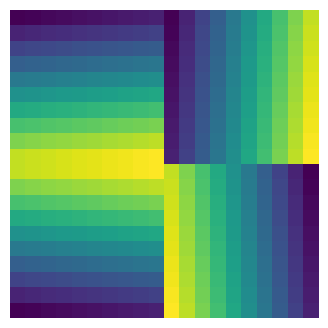

In [27]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid

im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of Axes
                 axes_pad=0.0,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.set_axis_off()
    ax.imshow(im)

plt.show()

In [36]:
# (grid_t * grid_h * grid_w) = 14308, (channel * temporal_patch_size * patch_size * patch_size) = 1176

a = np.random.rand(14308, 1176)
a[0].reshape((2,3,14,-1)).transpose(0,2,3,1).shape

(2, 14, 14, 3)

In [38]:
14*14

196

In [ ]:
# llava image inputs -> channel x height x wdith (3, 336, 336)
# image to embeddings :
# image size = (336, 336)
# kernel size = (14, 14) (stride = 14)
# (336 * 336) / (14 * 14) = 576 embeddings
# softmax(embeddings) -> interpolate and plot over image

In [5]:
processor.image_token

'<|image_pad|>'

In [3]:
# Image
url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]


# Preprocess the inputs
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'
#print(text_prompt)
#raise

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to(model.device)

In [8]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

In [ ]:
# image_grid_thw -> tensor([[  1,  98, 146]])

In [12]:
import torch
a = torch.tensor([[  1,  98, 146]])
a[0].prod()

tensor(14308)

In [9]:
import numpy as np
a = np.array([[  1,  98, 146]])
a.prod()

14308

In [4]:
model.visual

Qwen2VisionTransformerPretrainedModel(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
  )
  (rotary_pos_emb): VisionRotaryEmbedding()
  (blocks): ModuleList(
    (0-31): 32 x Qwen2VLVisionBlock(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): VisionFlashAttention2(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (mlp): VisionMlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): QuickGELUActivation()
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
    )
  )
  (merger): PatchMerger(
    (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=5120, out_features=5120, bias=True)
      (1): G

In [4]:
# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
print(output_text)

torch.Size([14308, 1176])
torch.Size([14308, 1280])


RuntimeError: No active exception to reraise

In [6]:
a = torch.rand(14308, 1280)
a = a.view(-1, 5120)
a.shape

torch.Size([3577, 5120])

In [32]:
torch.count_nonzero((inputs['input_ids'][0] == 151655).long())

tensor(3577, device='cuda:0')

In [27]:
inputs['input_ids'][0][50] == 151655

tensor(True, device='cuda:0')

In [2]:
1176*14

16464

In [9]:
model

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionFlashAttention2(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): S